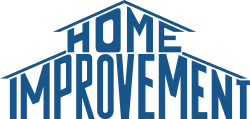

# King County Sale Price Analysis

**Author:** Marina Saito
***

## Overview

A client in King County, WA would like to advise homeowners regarding home improvement projects that will add to the sale price of their homes.  To accomplish this task, I created a model to evaluate how various features will affect the sale price of a home.  I ran a number of model iterations (see [Iterations notebook](../exploratory/Iterations.ipynb)) to identify a baseline model that best explains the variance in sale price.  I then used this model to help explain how various home improvement projects may affect the sale price.

## Business Problem

There are many home improvement projects that may increase the sale price of a home.  The improvements I considered in my housing analysis are:
 - Whether adding an open porch, an enclosed porch, or both an open and an enclosed porch will increase the sale price of a home
 - Whether upgrading to a forced-air heating system will increase the sale price of a home
 - Whether converting an attached garage into a bedroom will increase the sale price of a home

## Data Understanding

I used three datasets from the King County Department of Assessments for my analysis:
 - Real Property Sales Records, which includes information for each sale of real property between 2015 and 2020
 - Residential Building Records, which includes detailed description for each residential building
 - Parcel Records, which includes the details for each parcel of real property
 
A [data dictionary](../../references/King_County_Home_Sales_Data_Dictionary.pdf) describes the data within each of the datasets, and a "Look Up" table explains the meaning of many of the attributes included in the datasets

After running a number of iterations, I chose to use square root of the sale price, square root of the living space, and square root of the lot size as my base model.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import sys
sys.path.append('../../src')
import functions as fx

In [2]:
LookUp = pd.read_csv('../../data/raw/EXTR_LookUp.csv')
Parcel = pd.read_csv('../../data/raw/EXTR_Parcel.csv', dtype = str)
ResBldg = pd.read_csv('../../data/raw/EXTR_ResBldg.csv', dtype = str)
RPSale = pd.read_csv('../../data/raw/EXTR_RPSale.csv', dtype = str)

In [3]:
# Categorize Enclosed vs. Open Porches
ResBldg.loc[ResBldg.SqFtOpenPorch == '0', 'porch'] = 'enclosed'
ResBldg.loc[ResBldg.SqFtEnclosedPorch == '0', 'porch'] = 'open'
ResBldg.loc[(ResBldg.SqFtOpenPorch == '0') & 
            (ResBldg.SqFtEnclosedPorch == '0'), 'porch'] = 'none'
ResBldg.loc[(ResBldg.SqFtOpenPorch != '0') & 
            (ResBldg.SqFtEnclosedPorch != '0'), 'porch'] = 'both'

# Categorize Forced Air vs. Not
ResBldg.loc[ResBldg.HeatSystem != '5', 'HeatSystem'] = 'another'
ResBldg.loc[ResBldg.HeatSystem == '5', 'HeatSystem'] = 'forced_air'

# According to the notes, Residential buildings are classified as 
# buildings with 1, 2 or 3 living units
# Therefore, drop entries where NbrLivingUnits is not 1, 2 or 3
ResBldg = ResBldg[(ResBldg.NbrLivingUnits =='1') | 
                  (ResBldg.NbrLivingUnits =='2') | 
                  (ResBldg.NbrLivingUnits =='3')]

# Remove all-caps from DistrictName and remove spaces
Parcel.DistrictName = Parcel.DistrictName.str.title()
Parcel.DistrictName = Parcel.DistrictName.str.replace(' ', '')

# Create ID to merge dataframes
RPSale.Major = RPSale.Major + RPSale.Minor
RPSale.rename(columns = {'Major':'ID'}, inplace=True)
RPSale = RPSale[['ID', 'SalePrice', 'PropertyType', 'PrincipalUse']]

ResBldg.Major = ResBldg.Major + ResBldg.Minor
ResBldg.rename(columns={'Major':'ID'}, inplace=True)
ResBldg = ResBldg[['ID', 'SqFtTotLiving', 'SqFtGarageAttached', 
                   'porch', 'HeatSystem', 'Bedrooms']]

Parcel.Major = Parcel.Major + Parcel.Minor
Parcel.rename(columns = {'Major':'ID'}, inplace = True)
Parcel = Parcel[['ID', 'SqFtLot', 'DistrictName']]

# Create lookup table for property type in RPSale
PropTypeKey = LookUp[LookUp.LUType == 1]

# Merge dataframes
ResSale = pd.merge(RPSale, ResBldg, on = 'ID', how = 'inner')
ResSale = pd.merge(ResSale, Parcel, on = 'ID', how = 'left')
ResSale = ResSale.astype({'SalePrice':int, 'PropertyType':int, 
                          'SqFtTotLiving':int, 'Bedrooms':int, 
                          'SqFtLot':int})
ResSale = pd.merge(ResSale, PropTypeKey, left_on = 'PropertyType', 
                   right_on = 'LUItem', how = 'left')
ResSale = ResSale.drop(columns=['ID', 'PropertyType', 'LUType', 'LUItem'])

# Only keep entries that relate to residential properties
ResSale2 = ResSale[ResSale.LUDescription.str.contains('single family', 
                                                      na=False)]
ResSale3 = ResSale[ResSale.LUDescription.str.contains('residence', 
                                                      na=False)]
ResSale4 = ResSale[ResSale.LUDescription.str.contains('Residential condo', 
                                                      na=False)]
ResSale5 = ResSale[ResSale.LUDescription.str.contains('other residential', 
                                                      na=False)]
ResSale = pd.concat([ResSale2, ResSale3, ResSale4, ResSale5])
ResSale = ResSale[ResSale.PrincipalUse == '6']
ResSale = ResSale.drop(columns = ['PrincipalUse', 'LUDescription'])

# Categorize Properties with Attached Garages
ResSale.loc[ResSale.SqFtGarageAttached != '0', 'garage'] = 'attached'

# Determine number of bedrooms for properties with attached garages
NoRms = list(ResSale[ResSale.SqFtGarageAttached != '0'].Bedrooms.unique())
NoRms.sort()

# Adding bedroom to replace attached garage 
NoRms = [x + 1 for x in NoRms]

# Identify properties that replace attached garage with additional bedroom
ResSale.loc[(ResSale.Bedrooms.isin(NoRms)) & 
            (ResSale.SqFtGarageAttached == '0'), 'garage'] = 'renovated'
ResSale.dropna(subset=['garage'], inplace=True)
ResSale = ResSale.drop(columns=['SqFtGarageAttached', 'Bedrooms'])

# Drop low outliers for sale price
ResSale = ResSale[ResSale.SalePrice > 32500]
# Drop low outliers for Square Footage
ResSale = ResSale[ResSale.SqFtTotLiving > 200]
# shave off extremes (high sales price with low square footage 
# and low sales prices with high square footage)
ResSale = ResSale[(ResSale.SalePrice < 4000000) | 
                  (ResSale.SqFtTotLiving > 1000)]
ResSale = ResSale[(ResSale.SalePrice < 9000000) | 
                  (ResSale.SqFtTotLiving > 2000)]
ResSale = ResSale[(ResSale.SalePrice < 20000000)]
ResSale = ResSale[(ResSale.SalePrice > 2250000) | 
                  (ResSale.SqFtTotLiving < 10000)]
ResSale = ResSale[(ResSale.SalePrice > 1000000) | 
                  (ResSale.SqFtTotLiving < 9000)]
ResSale = ResSale[(ResSale.SalePrice > 250000) | 
                  (ResSale.SqFtTotLiving < 7500)]
ResSale = ResSale[(ResSale.SalePrice > 2500) | 
                  (ResSale.SqFtTotLiving < 5000)]

# SQRT of data
ResSale['sqrt_sale'] = np.sqrt(ResSale.SalePrice)
ResSale['sqrt_living'] = np.sqrt(ResSale.SqFtTotLiving)
ResSale['sqrt_lot'] = np.sqrt(ResSale.SqFtLot)

ResSale = ResSale.drop(columns=['SalePrice', 'SqFtTotLiving', 'SqFtLot'])

# Reorder so sqrt_sale is first column
cols = list(ResSale.columns)
cols = cols[4:7] + cols[:4]
ResSale = ResSale[cols]
ResSale.rename(columns = {'HeatSystem':'heat_system',
                          'DistrictName':'district_name'}, inplace=True)
ResSale.to_csv('../../data/processed/ResSale.csv')

## Base Model:  $ \sqrt{sale price} = {\beta}_{0} + {\beta}_{1}\sqrt{living} + {\beta}_{2}\sqrt{lot}$

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 2.211e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:53:24   Log-Likelihood:            -4.6805e+05
No. Observations:               70100   AIC:                         9.361e+05
Df Residuals:                   70097   BIC:                         9.361e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     137.8658      3.373     40.869      

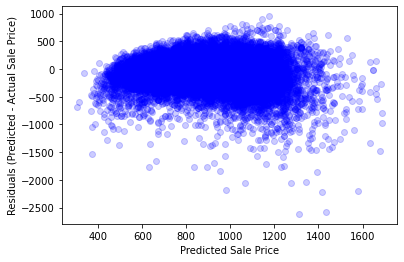

In [4]:
y = 'sqrt_sale'
X = ['sqrt_living', 'sqrt_lot']
fx.create_model(ResSale, y, X)

## Base Model Evaluation
$ \sqrt{sale price} = {\beta}_{0} + {\beta}_{1}\sqrt{living} + {\beta}_{2}\sqrt{lot}$
 - R-squared is 0.387, so the model only explains 38.7% of the variance in Sale Price
 - Overall p-value is 0.00, so the model is statistically significant at an alpha of 0.05
 - In this case, it is unclear what the intercept represents (since it is a property with 0 square feet of living space and a 0 square foot lot) but that property is expected to sell for \$19,007
     - Note: since the model uses the square root of the sale price, the intercept was squared to determine this value
 - For each additional square footage of living space, we expect the sale price to increase by \$242 
     - because each additional square root of living space increases the square root of the sales price by \$15.5514
 - For each additional square footage of lot space, we expect the sale price to decrease by \$0.02
 - p-values for intercept and coefficients are significant at an alpha of 0.05.  Thus, this model finds that the relationship between sale price, living space and lot size is significant

### Assumptions of Linear Regression:
***Linearity***
The null hypothesis is that the model is linearly predicted by the features.  The alternative hypothesis is that it is not.  Thus returning a high Rainbow p-value means that the current model does not violate the linearity assumption

***Normality***
The null hypothesis is that the residuals are normally distributed.  The alternative hypothesis is that they are not.  Thus returning a p-value of 0 under the Jarque-Bera test means that the current model violates the normality assumption.

***Homoscadasticity***
The null hypothesis is homoscedasticity.  The alternative hypothesis is heteroscedasticity.  Thus returning a low F-statistic p-value means that the current model violates the homoscedasticity assumption.

***Independence***
VIFs are less than 5, so it is reasonable to say that we are not violating the independence assumption (i.e., the features are not too colinear).

Because this model violates both the normality and the homoscadasticity assumptions, there appears to be a link between the independent variables and the error term.  In other words, there is likely a feature missing from the model, which should be investigated further.

## Adding Categorical Data
Will look at box plots to, at a glance, note any differences between the trends in sale price among the features I am analyzing.

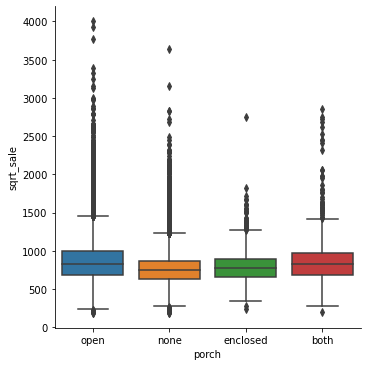

In [5]:
sns.catplot(x='porch', y='sqrt_sale', data=ResSale, kind='box')
plt.savefig('../../reports/figures/porch_box.png')

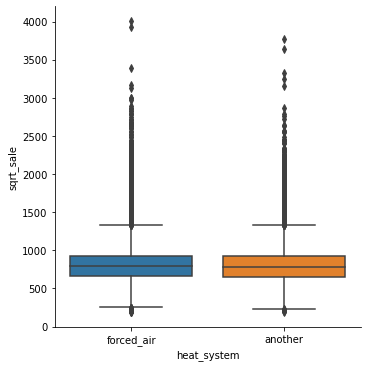

In [6]:
sns.catplot(x='heat_system', y='sqrt_sale', data=ResSale, kind='box')
plt.savefig('../../reports/figures/forced_air_box.png')

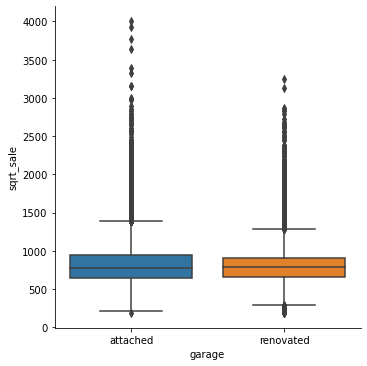

In [7]:
sns.catplot(x='garage', y='sqrt_sale', data=ResSale, kind='box')
plt.savefig('../../reports/figures/garage_box.png')

Box Plots indicate that there's not a substantial difference between the categorical groups in terms of spread and in terms of where the means fall.  Thus, it is unclear whether these features will be sufficient to explain the differences in sale price.

## Encode Categorical Data

In [8]:
# OneHotEncode Porch Data
categorical = ResSale[['sqrt_sale', 'porch']]
ohe = OneHotEncoder()
ohe.fit(categorical.drop('sqrt_sale', axis = 1))
categorical_trans = ohe.transform(categorical.drop('sqrt_sale', axis = 1))
df = pd.DataFrame(categorical_trans.todense(), 
                  columns=ohe.get_feature_names())
df.rename(columns = {'x0_both':'porch_both', 
                     'x0_enclosed':'porch_enclosed', 
                     'x0_open':'porch_open'}, inplace=True)
df = df.drop(columns=['x0_none'])
ResSale.reset_index(inplace=True)
ResSale = ResSale.join(df)
ResSale.drop(columns=['index', 'porch'], inplace = True)

# Label Encoder on HeatSystem
label_encoder = LabelEncoder()
label_encoder.fit(ResSale['heat_system'])
heat_labels = label_encoder.transform(ResSale['heat_system'])
ResSale['forced_air'] = heat_labels
ResSale.drop('heat_system', axis = 1, inplace = True)

# Label Encoder on Garage Renovated
label_encoder.fit(ResSale['garage'])
garage_labels = label_encoder.transform(ResSale['garage'])
ResSale['garage_renovated'] = garage_labels
ResSale.drop('garage', axis = 1, inplace = True)

# Evaluate Addition of Porch:

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     8925.
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:53:44   Log-Likelihood:            -4.6793e+05
No. Observations:               70100   AIC:                         9.359e+05
Df Residuals:                   70094   BIC:                         9.359e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        133.5068      3.409     39.

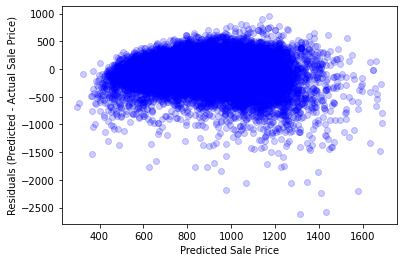

In [9]:
y = 'sqrt_sale'
X = ['sqrt_living', 'sqrt_lot', 'porch_open', 'porch_enclosed', 
     'porch_both']
fx.create_model(ResSale, y, X)

## Model Evaluation
$ \sqrt{sale price} = {\beta}_{0} + {\beta}_{1}\sqrt{living} + {\beta}_{2}\sqrt{lot} + {\beta}_{3}*{open porch} + {\beta}_{4}*{enclosed porch} + {\beta}_{5}*{both porches}$
 - R-squared is 0.389, so the model only explains 38.9% of the variance in Sale Price
 - Overall p-value is 0.00, so the model is statistically significant at an alpha of 0.05
 - Adding an open porch will increase the sale price of a home by \\$23
 - Adding an enclosed porch will increase the sale price of a home by \\$1826
 - Adding both an open and an enclosed porch will increase the sale price of a home by \\$4972
 - p-values for intercept and slope are significant at an alpha of 0.05.  Thus, this model finds that the relationship between sale price and the addition of a porch is significant


***Linearity***
The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.  Thus returning a high Rainbow p-value means that the current model does not violate the linearity assumption

***Normality***
The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  Thus, returning a p-value of 0 under the Jarque-Bera test means that the current model violates the normality assumption.

***Homoscadasticity***
The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  Thus returning a low F-statistic p-value means that the current model violates the homoscedasticity assumption.

***Independence***
VIFs are less than 5, so it is reasonable to say that we are not violating the independence assumption (i.e., the features are not too colinear).

The intercept changed slightly from the base model, but the coefficients for living space and lot size are very close to the base model.  The violation of both the normality and the homoscadasticity assumptions here likely originates from the base model.

# Evaluate Conversion to Forced-Air:

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                 1.518e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:53:48   Log-Likelihood:            -4.6764e+05
No. Observations:               70100   AIC:                         9.353e+05
Df Residuals:                   70096   BIC:                         9.353e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     163.2385      3.470     47.043      

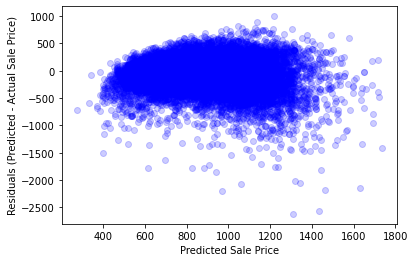

In [10]:
y = 'sqrt_sale'
X = ['sqrt_living', 'sqrt_lot', 'forced_air']
fx.create_model(ResSale, y, X)

## Model Evaluation
 $ \sqrt{sale price} = {\beta}_{0} + {\beta}_{1}\sqrt{living} + {\beta}_{2}\sqrt{lot} + {\beta}_{3}*{forced air}$
 - R-squared is 0.394, so the model only explains 39.4% of the variance in Sale Price
 - Overall p-value is 0.00, so the model is statistically significant at an alpha of 0.05
 - Converting to forced air will decrease the sale price of a home by \\$2427
 - p-values for intercept and slope are significant at an alpha of 0.05.  Thus, this model finds that the relationship between sale price and converting to forced air is significant

***Linearity***
The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.  Thus returning a high Rainbow p-value means that the current model does not violate the linearity assumption

***Normality***
The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  Thus, returning a p-value of 0 under the Jarque-Bera test means that the current model violates the normality assumption.

***Homoscadasticity***
The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  Thus returning a low F-statistic p-value means that the current model violates the homoscedasticity assumption.

***Independence***
VIF of living space is not less than 5, so we are violating the independence assumption.  Thus using forced-air appears to be dependent on living space.  This should be investigated further.

# Evaluate Conversion of Attached Garage to Bedroom:

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                 1.626e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:53:51   Log-Likelihood:            -4.6668e+05
No. Observations:               70100   AIC:                         9.334e+05
Df Residuals:                   70096   BIC:                         9.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           46.3260      3.734  

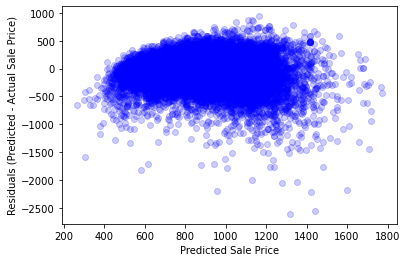

In [11]:
y = 'sqrt_sale'
X = ['sqrt_living', 'sqrt_lot', 'garage_renovated']
fx.create_model(ResSale, y, X)

## Model Evaluation
 $ \sqrt{sale price} = {\beta}_{0} + {\beta}_{1}\sqrt{living} + {\beta}_{2}\sqrt{lot} + {\beta}_{3}*{convert}$
 - R-squared is 0.410, so the model explains 41% of the variance in Sale Price
 - Overall p-value is 0.00, so the model is statistically significant at an alpha of 0.05
 - Converting an attached garage to a bedroom will increase the sale price of a home by \\$6256
 - p-values for intercept and slope are significant at an alpha of 0.05.  Thus, this model finds that the relationship between sale price and converting an attached garage to a bedroom is significant


***Linearity***
The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.  Thus returning a high Rainbow p-value means that the current model does not violate the linearity assumption

***Normality***
The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  Thus, returning a p-value of 0 under the Jarque-Bera test means that the current model violates the normality assumption.

***Homoscadasticity***
The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  Thus returning a low F-statistic p-value means that the current model violates the homoscedasticity assumption.

***Independence***
VIFs are less than 5, so it is reasonable to say that we are not violating the independence assumption (i.e., the features are not too colinear).

The intercept changed significantly from the base model (from 137.8658 to 46.326), as did the coefficients for living space and lot size.  Thus, although the assumptions of linear regression appear to be similar to the base model, the addition of this feature has a huge impact on the base model.  This should be investigated further.

# Determine Significance of Neighborhoods:

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     3469.
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:53:54   Log-Likelihood:            -4.4634e+05
No. Observations:               70100   AIC:                         8.928e+05
Df Residuals:                   70058   BIC:                         8.931e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.6873     11.76

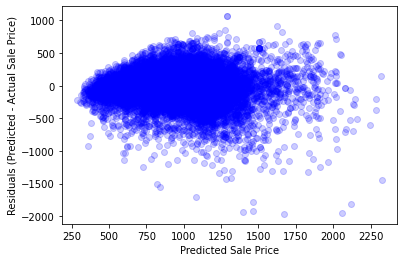

In [12]:
# OneHotEncode district name
categorical = ResSale[['sqrt_sale', 'district_name']]
ohe = OneHotEncoder(drop = 'first')
ohe.fit(categorical.drop('sqrt_sale', axis = 1))
categorical_trans = ohe.transform(categorical.drop('sqrt_sale', axis = 1))
df = pd.DataFrame(categorical_trans.todense(), 
                  columns=ohe.get_feature_names())
ResSale.reset_index(inplace=True)
ResSale = ResSale.join(df)
y = 'sqrt_sale'
X = ['sqrt_living', 'sqrt_lot', 'x0_Auburn', 'x0_BeauxArts', 'x0_Bellevue',
     'x0_BlackDiamond', 'x0_Bothell', 'x0_Burien', 'x0_Carnation',
     'x0_ClydeHill', 'x0_Covington', 'x0_DesMoines', 'x0_Duvall',
     'x0_Enumclaw', 'x0_FederalWay', 'x0_HuntsPoint', 'x0_Issaquah',
     'x0_Kenmore', 'x0_Kent', 'x0_KingCounty', 'x0_Kirkland',
     'x0_LakeForestPark', 'x0_MapleValley', 'x0_Medina', 'x0_MercerIsland',
     'x0_Milton', 'x0_Newcastle', 'x0_NormandyPark', 'x0_NorthBend',
     'x0_Pacific', 'x0_Redmond', 'x0_Renton', 'x0_Sammamish', 'x0_Seatac',
     'x0_Seattle', 'x0_Shoreline', 'x0_Skykomish', 'x0_Snoqualmie',
     'x0_Tukwila', 'x0_Woodinville', 'x0_YarrowPoint']
fx.create_model(ResSale, y, X)

## Model Evaluation
 - R-squared is 0.670, so the model explains 67% of the variance in Sale Price
 - The different neighborhoods helps to explain a significant portion of the Sale Price
 - Overall p-value is 0.00, so the model is statistically significant at an alpha of 0.05
 - p-values for intercept is no longer significant, nor are p-values for certain neighborhoods

***Linearity***
The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.  Thus returning a low Rainbow p-value means that the current model violates the linearity assumption

***Normality***
The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  Thus, returning a p-value of 0 under the Jarque-Bera test means that the current model violates the normality assumption.

***Homoscadasticity***
The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  Thus returning a low F-statistic p-value means that the current model violates the homoscedasticity assumption.

***Independence***
VIF of living space is not less than 5, so this model violates the independence assumption.

Although the addition of the different neighborhoods destroyed the base model, it caused R-squared to increase significantly.  It would be interesting to determine how separating the models based on neighborhoods would affect the base model.  This should be investigated further.

# Evaluation

Based on my analysis:
 - The addition of an open porch will increase the sale price of a home by \\$23
 - The addition of an enclosed porch will increase the sale price of a home by \\$1826
 - The addition of both an open porch and an enclosed porch will increase the sale price of a home by \\$4972
 - The conversion of a heating system to forced-air will decrease the sale price of a home by \\$2427
 - The conversion of an attached garage to a bedroom will increase the sale price of a home by \\$6256
 
# Conclusions
I provide the following recommendations to the client:
 - Although the addition of an open porch is expected to increase the sale price of a home, according to my model, it will only increase the sale price by \\$23, which is likely to be less than the cost of adding an open porch.  Thus, I do not recommend adding an open porch to increase the sale price of a home.
 - Both the addition of an enclosed porch, or the addition of both an enclosed porch and an open porch is expected to increase the sale price of a home by \\$1826 and \\$4972, respectively, so I recommend this option be investigated further (i.e., the cost for adding these features should be evaluated to determine if it is worth the cost of the renovation).
 - The conversion to a forced-air heating system is expected to decrease the sale price of a home, so I do not recommend this renovation
 - The conversion of an attached garage to a bedroom is expected to increase the sale price by \\$6256, so I recommend this option be investigated further to determine whether it is worth the cost of the renovation
 
# Next Steps
 - As discussed above, some anomolies were identified in the models that need to be investigated further
 - Neighborhoods appears to have a significant effect on the sale price, so I recommend that the sale price be evaluated based on the neighborhood in which the property is located
 - Certain features are expected to increase the sale price of a home.  I recommend investigating the cost for adding these features to determine whether the feature is worth the cost of the renovation
     - for example, consider effect of converting open porch into an enclosed porch